<a href="https://colab.research.google.com/github/JuanM-GG/modelos-tesis/blob/main/optimizacion_parametrica_inhibicion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Título: Optimización paramétrica 

Autor: Juan Manuel Gutiérrez García

Fecha: enero 2021

# Optimización paramétrica

En esta sección el modelo que se emplea para realizar la optimización describe un tipo de operación tipo lote. Las variables experimentales de las que se tienen mediciones son biomasa, $x$, sustrato, $s$ y producto, $p$. La fermentacións se realiza durante un intervalo de tiempo de 60 horas, tomando mediciones cada 4 horas. El interés de realizar la optimización paramétrica es usar los parámetros obtenidos para caracterizar la fermentación, realizar un análisis estadístico y estudiar estrategias de alimentación al biorreactor. 

Del balance de masa se tiene

Balance de materia para biomasa

$$
acumulación\ de\ biomasa= \ generación
$$
\
$$
\frac{d(xV)}{dt} = V r_x 
$$
Dado que el volumen es constante
$$
\frac{dx}{dt} = r_x \tag{1}
$$

Balance de materia para sustrato


$$
acumulación\ de\ sustrato=\ - consumo
$$
\
$$
\frac{d(sV)}{dt} =  - V r_s 
$$
Considerado

$$
r_s = \frac{1}{Y_{xs}} r_x
$$

Se tiene
$$
\frac{ds}{dt} =  - \frac{1}{Y_{xs}} r_x  \tag{2}
$$

Balance de materia para producto

$$
acumulación\ de\ producto=\ generación
$$
\
$$
\frac{d(pV)}{dt} =  V r_p 
$$

Considerado

$$
r_p = Y_{px} r_x
$$


Se tiene

$$
\frac{dp}{dt} =  Y_{px} r_x  \tag{3}
$$

Siendo

$$
r_x = \mu_{max} \left( \frac{s}{k_s + s} \right) x \tag{4}
$$

In [ ]:
# instalar librerias
install.packages("xlsx")
install.packages("GA")
install.packages("deSolve")
install.packages("FME")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rJava’, ‘xlsxjars’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘foreach’, ‘iterators’, ‘RcppArmadillo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rootSolve’, ‘coda’, ‘minpack.lm’, ‘minqa’




In [ ]:
# cargar librerías
library(xlsx)
library(GA)
library(deSolve)
library(ggplot2)
library(FME)

Loading required package: foreach

Loading required package: iterators

Package 'GA' version 3.2
Type 'citation("GA")' for citing this R package in publications.


Attaching package: ‘GA’


The following object is masked from ‘package:utils’:

    de


Loading required package: rootSolve

Loading required package: coda



In [ ]:
# establecer modelo para reactor tipo lote 
model <- function(time, state, parms) {
  with(as.list(c(state, parms)), {

    # tasas de crecimiento de biomasa
    mu = mu_max*(s/(ks + s))

    # velocidad de crecimiento de biomasa
    rx = mu*x

    # velocidad de consumo de sustrato
    rs = (1/Yxs)*rx
    
    # velocidad de generación de producto
    rp = Ypx*rx

    # balances de materia para el sustrato
    dsdt <- - rs

    # balance de materia para la biomasa
    dxdt <- rx

    # balance de materia para el producto 
    dpdt <-  rp

    return(list(c(dsdt, dxdt, dpdt)))
  })
}

# Cargar los datos experimentales

In [ ]:
# cargar los datos 
data_it <- read.xlsx("IT.xlsx", sheetIndex = 1)
data_km <- read.xlsx("KM.xlsx", sheetIndex = 1)
data_pk <- read.xlsx("PK.xlsx", sheetIndex = 1)
data_zb <- read.xlsx("ZB.xlsx", sheetIndex = 1)
data_zr <- read.xlsx("ZR.xlsx", sheetIndex = 1)

In [ ]:
# revisar los datos 
str(data_it)

'data.frame':	16 obs. of  4 variables:
 $ time: num  0 4 8 12 16 20 24 28 32 36 ...
 $ x   : num  0.2 0.25 1.15 1.65 2.6 ...
 $ p   : num  2.5 13.9 27.3 28.8 31.8 ...
 $ s   : num  44.9 NA 37 NA 29.1 ...


In [ ]:
# revisar los datos 
str(data_km)

'data.frame':	16 obs. of  4 variables:
 $ time: num  0 4 8 12 16 20 24 28 32 36 ...
 $ x   : num  0.2 0.65 0.2 1.1 0.2 1.2 1.75 2.7 3.3 2.65 ...
 $ p   : num  2.58 9.43 7.63 16.63 23.85 ...
 $ s   : num  63 NA 44.7 NA 47.3 ...


In [ ]:
# revisar los datos 
str(data_pk)

'data.frame':	16 obs. of  4 variables:
 $ time: num  0 4 8 12 16 20 24 28 32 36 ...
 $ x   : num  0.2 1.15 1.68 2.2 2.85 ...
 $ p   : num  3.93 7.58 16.61 23.51 27.53 ...
 $ s   : num  88.5 NA 65.8 NA 66.5 ...


In [ ]:
# revisar los datos 
str(data_zb)

'data.frame':	17 obs. of  4 variables:
 $ time: num  0 4 8 12 16 20 24 28 32 36 ...
 $ x   : num  0.2 0.65 0.2 1.1 0.2 ...
 $ p   : num  2.74 4.93 10.89 14.03 15.07 ...
 $ s   : num  46.4 NA 45.8 NA 34.9 ...


In [ ]:
# revisar los datos 
str(data_zr)

'data.frame':	16 obs. of  4 variables:
 $ time: num  0 4 8 12 16 20 24 28 32 36 ...
 $ x   : num  4.15 4.25 5.2 6.7 6.75 ...
 $ p   : num  1.83 8.49 12.3 11.86 19.5 ...
 $ s   : num  43.6 NA 38.1 NA 20.3 ...


De las salidas anteriores vemos que los datos se componen de cuatro variables: tiempo (time), biomasa (x), producto (p) y sustrato (s). Se aprecia que se tienen 16 observaciones de cada variable, sin embargo, existen `NA` en la variable s. Esto no es un problema ya que para la optimización paramétrica no se requieren la totalidad de las observaciones

# Establecer función objetivo

En la optimización paramétrica lo más común es definir la función objetivo como la función de costo:

$$
F(p) = \sum_{i = 1}^{n} \left( \hat{x}_i - x_{exp,i} \right)^{2}
$$

Donde $n$ es el número de observaciones en nuestros datos, $\hat{x}_i$ representa la i-ésima predicción hecha con el modelo y $x_{exp,i}$ la i-ésima observación expermiental.

In [ ]:
cost <- function(x, data) {
# x representa el vector de parámetros que hay que optimizar
  names(x) <- names(p)
  out <- ode(y = c(s = data$s[1], x = data$x[1], p = data$p[1]), 
            times = data$time, 
            parms = x, 
            func = model, 
            method = "rk4")
# el menos es porque queremos minimizar la función de costo y el GA maximiza
  f <- - modCost(model = out, obs = data)$model
  return(f)
}


Esta función recibe un vector de parámetros, le asigna los nombres del vector p, y utiliza los valores contenidos en el vector para simular el modelo y comparar con los datos expermientales. El valor negativo es debido a que la función ga() que realiza la optimización busca maximizar la función cost().

In [ ]:
# parámetros del modelo escogidos al azar solo para probar la función costo 
p <- c(mu_max = 1.2, ks = 280, Yxs = 0.2, Ypx = 4)
# timepo para la simulación
times <- data_it$time
# probar la función costo con los datos de data_it
cat("error: ",  -cost(p, data_it))


error:  2351.144

# Realizar la optimización paramétrica usando algoritmos genéticos 

Para el correcto funcionamiento del algoritmo genético usando la función `ga()` es necesario establecer un valor adecuado de los parámetros `popSize`, `pcrossover`, `pmutation`, `elitism` y `maxiter`. Además se deben establecer los valores mínimos y máximos para cada uno de los parámetros a optimizar 

Tabla 1. Valores de parámetros usados en la optimización

| parámetro | valor|
|:---:|:---:|
| tamaño de población | 100 |
| probabilidad de cruzamiento | 0.8 |
| probabilidad de mutación | 0.1 | 
| elitismo | 2 |
| número de generaciones | 100 |

Tabla 2. Valores mínimos y máximos de los parámetros a optimizar

| parámetro | mínimo | máximo |
|:---:|:---:|:---:|
| $\mu_{max} $ (1/h) | 0 | 3 |
| $k_s$ (g/L) | 0 | 500 |
| $Y_{xs}$ | 0 | 1 | 
| $Y_{px}$ | 0 | 20 |

## Optimización paramétrica con datos de Isstchenkia terrícola

In [ ]:
# realizar la optimización paramétrica
set.seed(123) # para reproducir estos resultados 
GA_it <- ga(type = "real-valued",
      fitness = cost, 
      data = data_it,
      lower = rep(0, 4),
      upper = c(3,500,1,20),
      popSize = 50,
      pcrossover = 0.8,
      pmutation = 0.1,
      elitism = 2,
      maxiter = 100,
      maxFitness = 0, 
      names = names(p))

In [ ]:
print(GA_it@solution)
cat("error: ", -GA_it@fitnessValue)

      mu_max       ks      Yxs      Ypx
[1,] 1.59137 323.8468 0.104285 7.340216
error:  1587.531

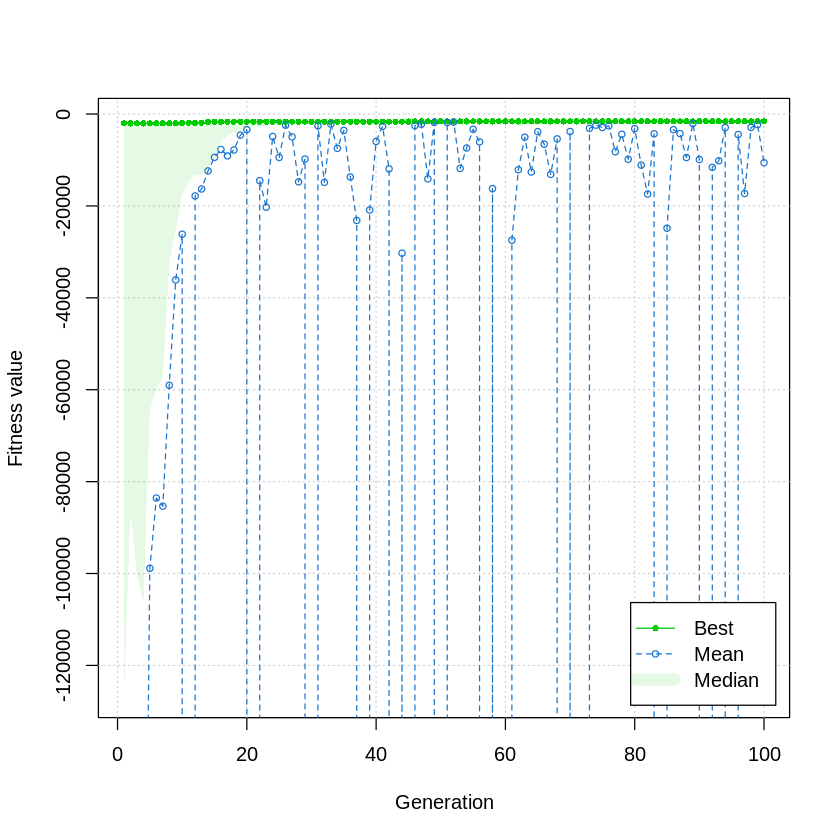

In [ ]:
# mostrar evolución del algoritmo
plot(GA_it)

Como se puede apreciar, el algoritmo no tardó mucho en llegar a la solución óptima. 

### Comparar simulación con parámetros óptimos y datos experimentales

In [ ]:
# parámetros óptimos para la comparación 
p_opt_it <- GA_it@solution[1,]

In [ ]:
# condiciones iniciales (siempre debemos tomar las condiciones iniciales para la simulación
# de los datos experimentales si lo que queremos es comparar u optimizar)
s <- c(s = data_it$s[1], x = data_it$x[1], p = data_it$p[1])

In [ ]:
# tiempo de integración (lo mismo con el tiempo)
times <- data_it$time

In [ ]:
out_it <- ode(y=s, times = times, parms = p_opt_it, func = model, method = "rk4")
out_it <- as.data.frame(out_it)

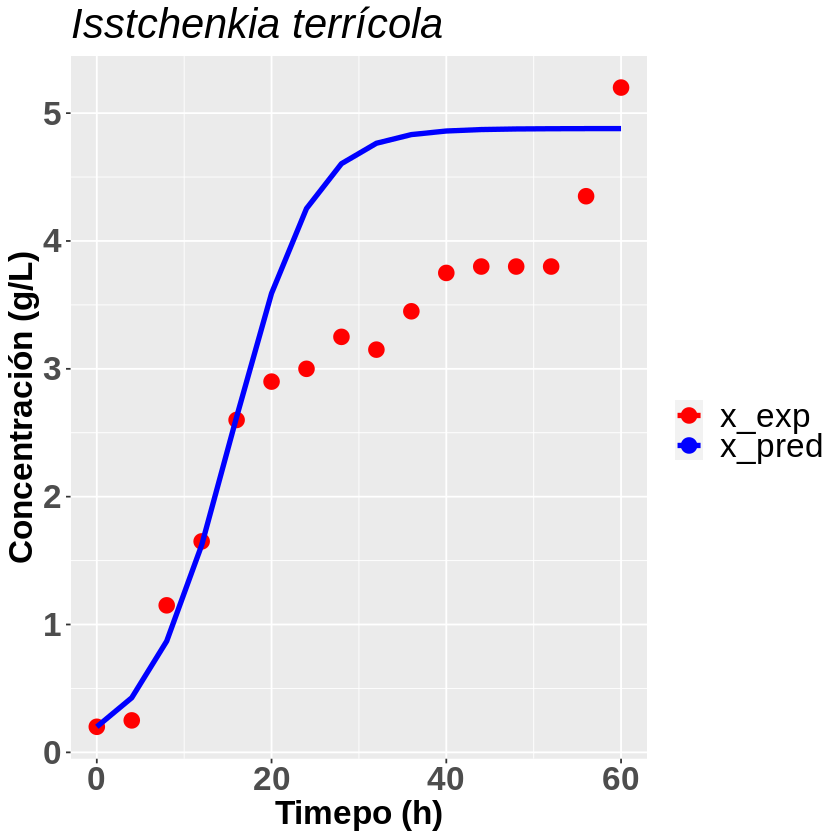

In [ ]:
# comparamos modelo y datos experimentales (biomasa)
ggplot(data_it, aes(x=time)) +
  geom_point(aes(y = x, color = "x_exp"), size = 4) +
  geom_line(data = out_it, aes(y = x, color = "x_pred"), lwd = 1.5) +
  scale_color_manual("", breaks = c("x_exp", "x_pred"), values = c("red", "blue")) +
  xlab("Timepo (h)") +
  ylab("Concentración (g/L)") +
  labs(title = "Isstchenkia terrícola") +
  theme(
        plot.title = element_text(size=25,face = "italic"),
        axis.text=element_text(size=20, face = "bold"),
        axis.title=element_text(size=20,face="bold"),
        legend.title = element_text(size=20), 
        legend.text = element_text(size=20))

Vemos que el ajuste es bueno para las observaciones antes de la hora 20. Después el modelo predice valores mayores de biomasa que los que se observan en los datos. Lo anterior se puede deber a un efecto de inhibición o muerte celular que no se representa en el modelo. 

Warning message:
“Removed 7 rows containing missing values (geom_point).”


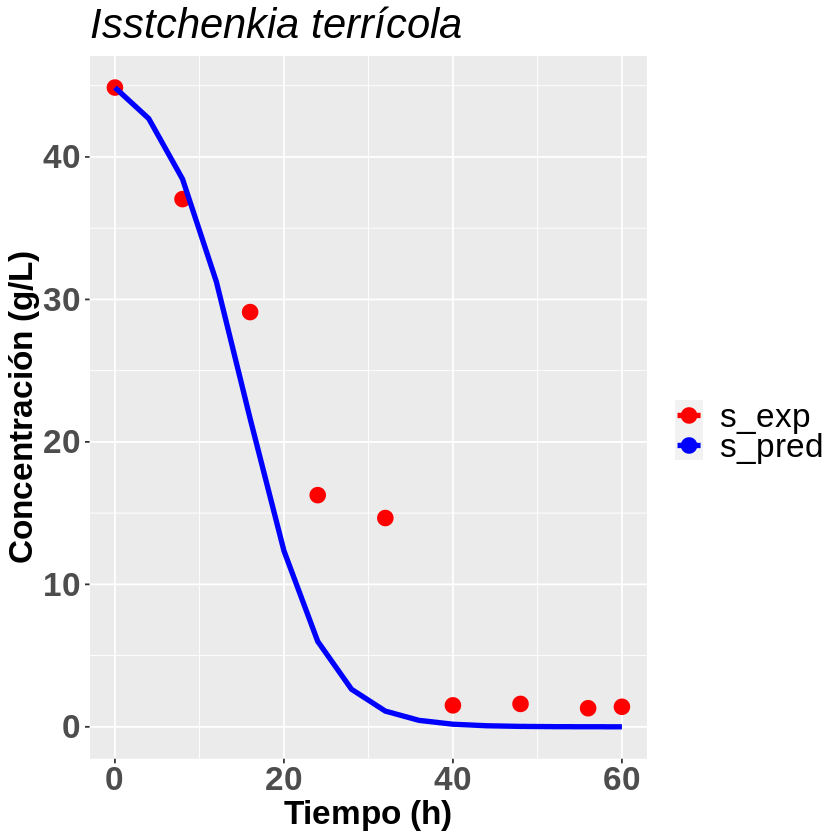

In [ ]:
# comparamos modelo y datos experimentales (sustrato)
ggplot(data_it, aes(x=time)) +
  geom_point(aes(y = s, color = "s_exp"), size = 4) +
  geom_line(data = out_it, aes(y = s, color = "s_pred"), lwd = 1.5) +
  scale_color_manual("", breaks = c("s_exp", "s_pred"), values = c("red", "blue")) +
  xlab("Tiempo (h)") +
  ylab("Concentración (g/L)")  +
  labs(title = "Isstchenkia terrícola") +
  theme(
        plot.title = element_text(size=25,face = "italic"),
        axis.text=element_text(size=20, face = "bold"),
        axis.title=element_text(size=20,face="bold"),
        legend.title = element_text(size=20), 
        legend.text = element_text(size=20))

El ajuste es bueno ya que la mayoria de las observaciones se encuentran cerca de las predicciones hechas por el modelo. La única discrepancia es en las observaciones entre la hora 20 y la hora 40 las cuales se alejan un poco del modelo 

El "warning" es debido a los datos faltantes de $s$

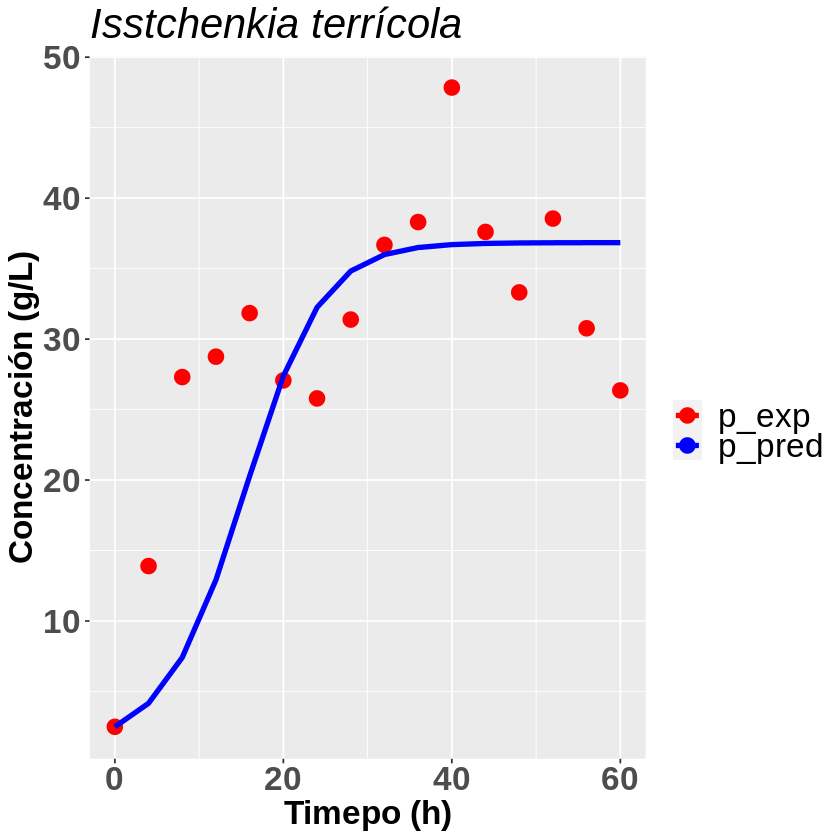

In [ ]:
# comparamos modelo y datos experimentales (producto)
ggplot(data_it, aes(x=time)) +
  geom_point(aes(y = p, color = "p_exp"), size = 4) +
  geom_line(data = out_it, aes(y = p, color = "p_pred"), lwd = 1.5) +
  scale_color_manual("", breaks = c("p_exp", "p_pred"), values = c("red", "blue")) +
  xlab("Timepo (h)") +
  ylab("Concentración (g/L)") +
  labs(title = "Isstchenkia terrícola") +
  theme(plot.title = element_text(size=25,face = "italic"),
        axis.text=element_text(size=20, face = "bold"),
        axis.title=element_text(size=20,face="bold"),
        legend.title = element_text(size=20), 
        legend.text = element_text(size=20))

Aquí vemos una mayor dispersión en los datos experimentales. Aun así el ajuste parece ser bueno ya que se pueden observar un número similar de observaciones por arriba y por abajo de las predicciones 


Tabla 3. Parámetros encontrados al hacer la optimización con datos de la levadura *Pichia kluyveri*

|Parámetro|	Valor|
|:---:|:---:|
|$\mu_{max}$|	$1.591 h^{-1}$|
|$k_s$|	$323.846$ g/L|
|$Y_{xs}$|	$0.104$|
|$Y_{px}$|	$7.340$|

In [ ]:
print(p_opt_it)

    mu_max         ks        Yxs        Ypx 
  1.591370 323.846765   0.104285   7.340216 


Una forma alternativa de calcular el valor de los rendimientos $Y_{xs}$ y $Y_{px}$ es usando los valores iniciales y finales de nuestro conjunto de datos a través de las siguientes fórmulas 

$$
Y_{xs} = \frac{x_{end} - x_{ini}}{s_{ini} - s_{end}} \tag{5}
$$

y

$$
Y_{px} = \frac{p_{end} - p_{ini}}{x_{end} - x_{ini}} \tag{6}
$$

A continuación empleamos (5) y (6) para calcular los rendimientos y comparamos con los resultados obtenidos de la optimización 


In [ ]:
# función para calcular rendimiento biomasa-sustrato
yield_xs <- function(data) {
    
    n <- length(data$time)

    Yxs <- (data$x[n] - data$x[1]) / (data$s[1] - data$s[n])

    return(Yxs)
}

In [ ]:
# función para calcular rendimiento producto-biomasa
yield_px <- function(data) {
    
    n <- length(data$time)

    Ypx <- (data$p[n] - data$p[1]) / (data$x[n] - data$x[1])

    return(Ypx)
}

### Rendimientos 
Rendimientos obtenidos mediante (5) y (6) 

In [ ]:
cat("Yxs: ", yield_xs(data_it), "\n")
cat("Ypx: ", yield_px(data_it))

Yxs:  0.1150363 
Ypx:  4.772557

Rendimientos obtenidos de la optimización paramétrica

In [ ]:
cat("Yxs: ", p_opt_it["Yxs"], "\n")
cat("Ypx: ", p_opt_it["Ypx"])

Yxs:  0.104285 
Ypx:  7.340216

Vemos que existe una diferncia considerable entre $Y_{px}$ calculado mediante la optimización y $Y_{px}$ calculado con (6). Esto indica que debemos tener cuidado al describir la forma en la que se han calculado los rendimientos 

## Optimización paramétrica con datos de Kluyveromyces marxianus var. Drosophilarum

In [ ]:
# realizar la optimización paramétrica
set.seed(123) # para reproducir estos resultados 
GA_km <- ga(type = "real-valued",
      fitness = cost, 
      data = data_km,
      lower = rep(0, 4),
      # aquí aumentamos km_max para mejor ajuste
      upper = c(3,500,1,20),
      popSize = 50,
      pcrossover = 0.8,
      pmutation = 0.1,
      elitism = 2,
      maxiter = 100,
      maxFitness = 0,
      names = names(p))

In [ ]:
print(GA_km@solution)
cat("error: ", -GA_km@fitnessValue)

        mu_max       ks        Yxs      Ypx
[1,] 0.8762666 322.3249 0.09362811 6.880134
error:  1382.395

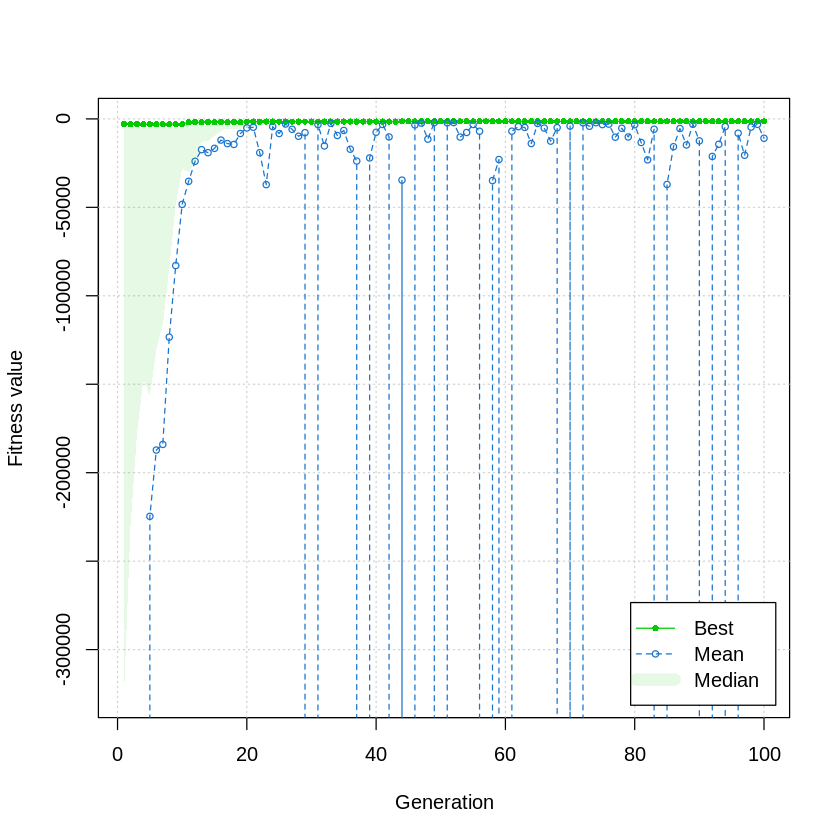

In [ ]:
# mostrar evolución del algoritmo
plot(GA_km)

### Comparar simulación con parámetros óptimos y datos experimentales

In [ ]:
# parámetros óptimos para la comparación 
p_opt_km <- GA_km@solution[1,]

In [ ]:
# condiciones iniciales (siempre debemos tomar las condiciones iniciales para la simulación
# de los datos experimentales si lo que queremos es comparar u optimizar)
s <- c(s = data_km$s[1], x = data_km$x[1], p = data_km$p[1])

In [ ]:
# tiempo de integración (lo mismo con el tiempo)
times <- data_km$time

In [ ]:
out_km <- ode(y=s, times = times, parms = p_opt_km, func = model, method = "rk4")
out_km <- as.data.frame(out_km)

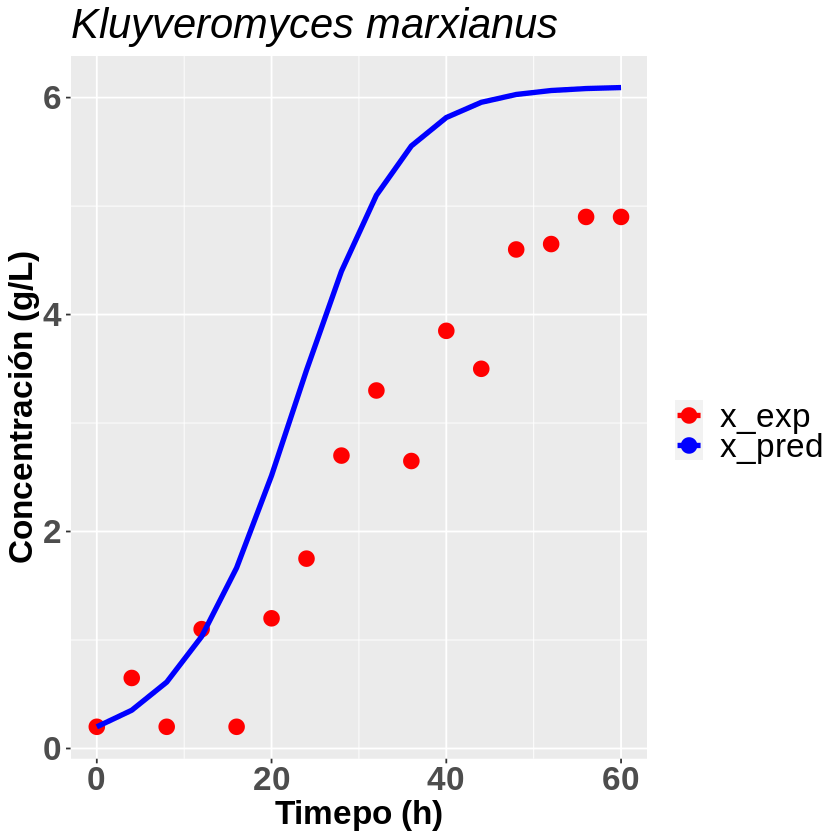

In [ ]:
# comparamos modelo y datos experimentales (biomasa)
ggplot(data_km, aes(x=time)) +
  geom_point(aes(y = x, color = "x_exp"), size = 4) +
  geom_line(data = out_km, aes(y = x, color = "x_pred"), lwd = 1.5) +
  scale_color_manual("", breaks = c("x_exp", "x_pred"), values = c("red", "blue")) +
  xlab("Timepo (h)") +
  ylab("Concentración (g/L)") +
  labs(title = "Kluyveromyces marxianus") +
  theme(
        plot.title = element_text(size=25,face = "italic"),
        axis.text=element_text(size=20, face = "bold"),
        axis.title=element_text(size=20,face="bold"),
        legend.title = element_text(size=20), 
        legend.text = element_text(size=20))

Podemos ver que el ajuste no es muy bueno, sin embargo, tanto el modelo como los datos experimentales muestran el mismo comportamiento. Al inico se aprecia un crecimiento acelerado que dura hasta la hora 40. De aquí en adelante se observa la fase estacionaria. 

Warning message:
“Removed 7 rows containing missing values (geom_point).”


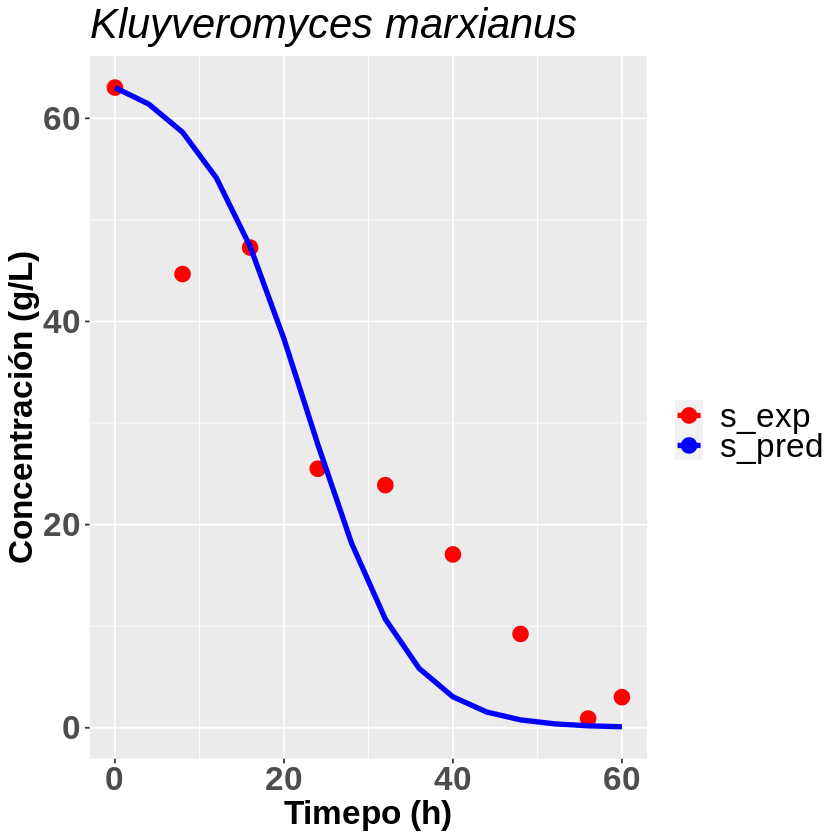

In [ ]:
# comparamos modelo y datos experimentales (sustrato)
ggplot(data_km, aes(x=time)) +
  geom_point(aes(y = s, color = "s_exp"), size = 4) +
  geom_line(data = out_km, aes(y = s, color = "s_pred"), lwd = 1.5) +
  scale_color_manual("", breaks = c("s_exp", "s_pred"), values = c("red", "blue")) +
  xlab("Timepo (h)") +
  ylab("Concentración (g/L)") +
  labs(title = "Kluyveromyces marxianus") +
  theme(
        plot.title = element_text(size=25,face = "italic"),
        axis.text=element_text(size=20, face = "bold"),
        axis.title=element_text(size=20,face="bold"),
        legend.title = element_text(size=20), 
        legend.text = element_text(size=20))

Se aprecia que el modelo describe bien los datos. El ajuste es mejor con las primeras observaciones. Existe una pequeña discrepancia con los datos de la hora 40 y 48, pero después el ajuste vuelve a ser bueno. 

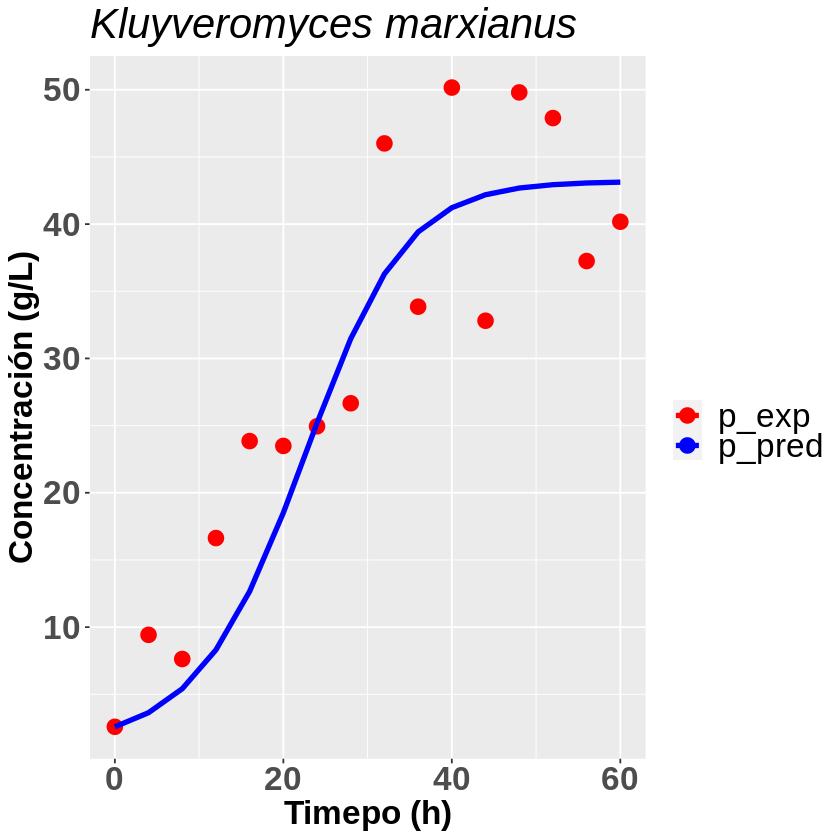

In [ ]:
# comparamos modelo y datos experimentales (producto)
ggplot(data_km, aes(x=time)) +
  geom_point(aes(y = p, color = "p_exp"), size = 4) +
  geom_line(data = out_km, aes(y = p, color = "p_pred"), lwd = 1.5) +
  scale_color_manual("", breaks = c("p_exp", "p_pred"), values = c("red", "blue")) +
  xlab("Timepo (h)") +
  ylab("Concentración (g/L)") +
  labs(title = "Kluyveromyces marxianus") +
  theme(
        plot.title = element_text(size=25,face = "italic"),
        axis.text=element_text(size=20, face = "bold"),
        axis.title=element_text(size=20,face="bold"),
        legend.title = element_text(size=20), 
        legend.text = element_text(size=20))

Se observa una mayor dispersión en los datos experimentales que en el caso de la biomasa y el sustrato. Aun así, el ajuste es bueno ya que existe un número similar de observaciones que quedan arriba y abajo de las predicciones. 


Tabla 4. Parámetros encontrados al hacer la optimización con datos de la levadura *Kluyveromyces marxianus*

|Parámetro|	Valor|
|:---:|:---:|
|$\mu_{max}$|	$0.876 h^{-1}$|
|$k_s$|	$322.324$ g/L|
|$Y_{xs}$|	$0.093$|
|$Y_{px}$|	$6.880$|

In [ ]:
print(p_opt_km)

      mu_max           ks          Yxs          Ypx 
  0.87626655 322.32494402   0.09362811   6.88013378 


### Rendimientos

Rendimientos obtendios mediante (5) y (6)

In [ ]:
cat("Yxs: ", yield_xs(data_km), "\n")
cat("Ypx: ", yield_px(data_km))

Yxs:  0.07830906 
Ypx:  7.998766

Rendimientos obtenidos de la optimización paramétrica

In [ ]:
cat("Yxs: ", p_opt_km["Yxs"], "\n")
cat("Ypx: ", p_opt_km["Ypx"])

Yxs:  0.09362811 
Ypx:  6.880134

Vemos que el rendimiento $Y_{xs}$ obtendio con (5) es menor que el obtenido de la optimización, mientras que el rendimiento $Y_{px}$ obtenido con (6) es mayor. La diferencia no es muy grande y podemos ver congruencia entre las fórmulas y los resultados de la optimización.

## Optimización paramétrica con datos de *Pichia kluyveri*

In [ ]:
# realizar la optimización paramétrica
set.seed(123) # para reproducir estos resultados 
GA_pk <- ga(type = "real-valued",
      fitness = cost, 
      data = data_pk,
      lower = rep(0, 4),
      upper = c(3,500,1,20),
      popSize = 50,
      pcrossover = 0.8,
      pmutation = 0.1,
      elitism = 2,
      maxiter = 100,
      maxFitness = 0,
      names = names(p))

In [ ]:
print(GA_pk@solution)
cat("error: ", -GA_pk@fitnessValue)

        mu_max       ks        Yxs      Ypx
[1,] 0.6694644 390.1276 0.08225718 5.252351
error:  2916.584

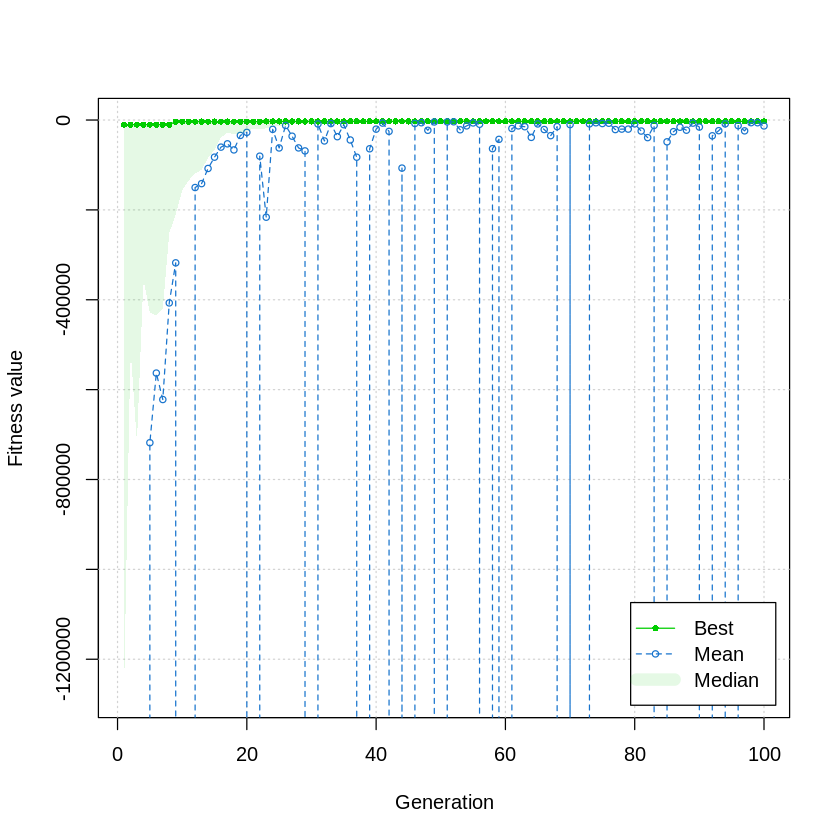

In [ ]:
# mostrar evolución del algoritmo
plot(GA_pk)

### Comparar simulación con parámetros óptimos y datos experimentales

In [ ]:
# parámetros óptimos para la comparación 
p_opt_pk <- GA_pk@solution[1,]

In [ ]:
# condiciones iniciales (siempre debemos tomar las condiciones iniciales para la simulación
# de los datos experimentales si lo que queremos es comparar u optimizar)
s <- c(s = data_pk$s[1], x = data_pk$x[1], p = data_pk$p[1])

In [ ]:
# tiempo de integración (lo mismo con el tiempo)
times <- data_pk$time

In [ ]:
# simular con parámetros óptimos 
out_pk <- ode(y=s, times = times, parms = p_opt_pk, func = model, method = "rk4")
out_pk <- as.data.frame(out_pk)

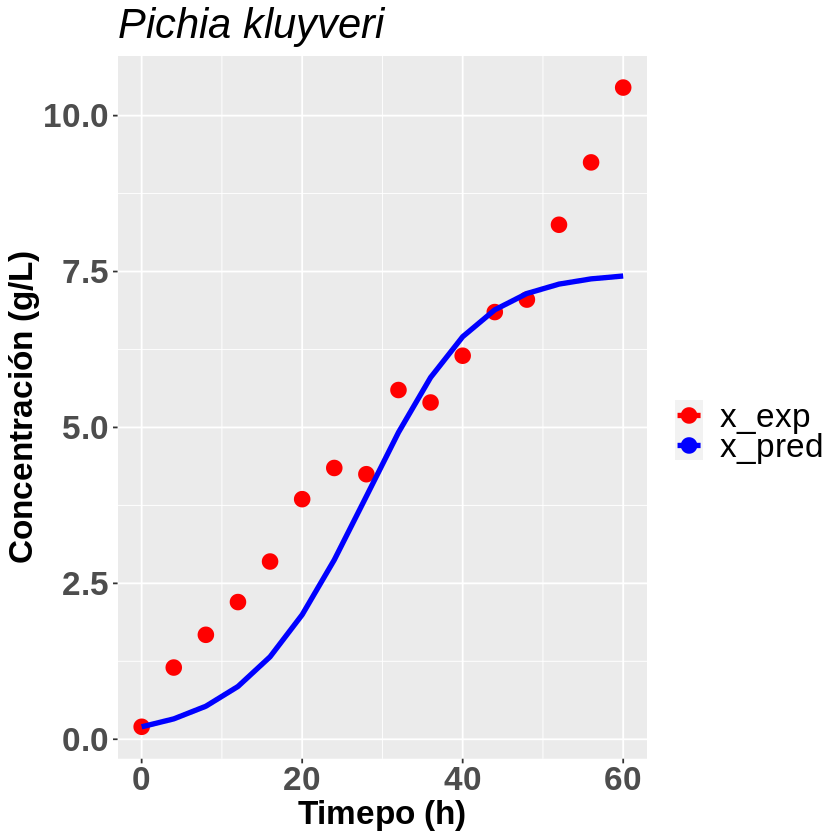

In [ ]:
# comparamos modelo y datos experimentales (biomasa)
ggplot(data_pk, aes(x=time)) +
  geom_point(aes(y = x, color = "x_exp"), size = 4) +
  geom_line(data = out_pk, aes(y = x, color = "x_pred"), lwd = 1.5) +
  scale_color_manual("", breaks = c("x_exp", "x_pred"), values = c("red", "blue")) +
  xlab("Timepo (h)") +
  ylab("Concentración (g/L)") +
  labs(title = "Pichia kluyveri") +
  theme(
        plot.title = element_text(size=25,face = "italic"),
        axis.text=element_text(size=20, face = "bold"),
        axis.title=element_text(size=20,face="bold"),
        legend.title = element_text(size=20), 
        legend.text = element_text(size=20))

Vemos que la concentración de biomasa parece incrementar de forma lineal en los datos experimentales. Por esta razón el modelo difiere un poco de los datos. Aun así, el modelo se ajusta bien a los datos ya que hay una cantidad similar de observaciones por arriba y abajo de las predicciones hechas con el modelo 

Warning message:
“Removed 7 rows containing missing values (geom_point).”


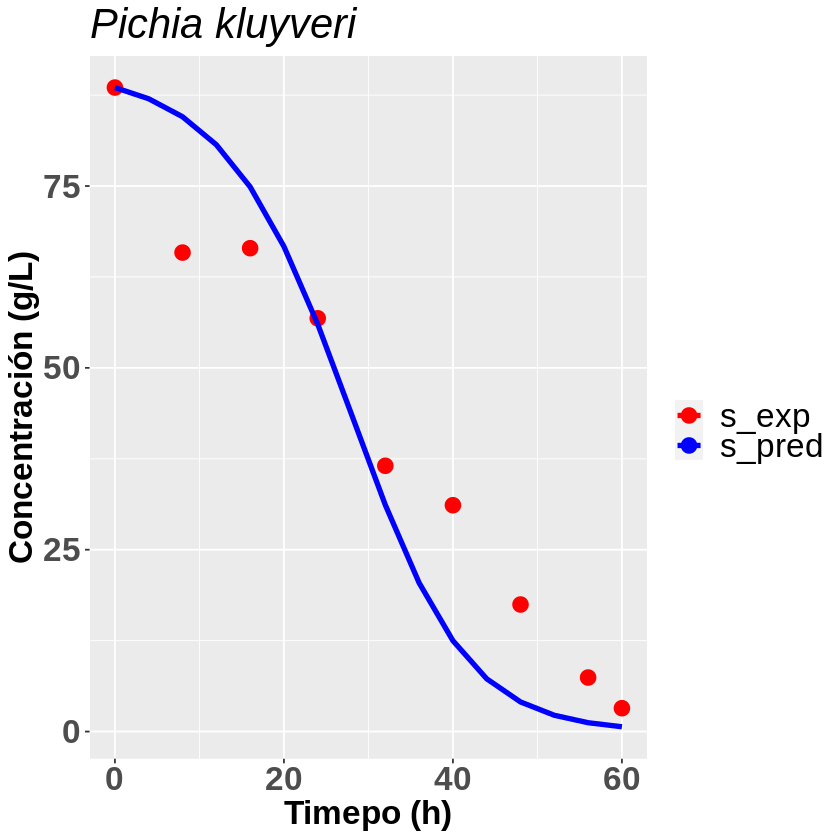

In [ ]:
# comparamos modelo y datos experimentales (sustrato)
ggplot(data_pk, aes(x=time)) +
  geom_point(aes(y = s, color = "s_exp"), size = 4) +
  geom_line(data = out_pk, aes(y = s, color = "s_pred"), lwd = 1.5) +
  scale_color_manual("", breaks = c("s_exp", "s_pred"), values = c("red", "blue")) +
  xlab("Timepo (h)") +
  ylab("Concentración (g/L)") +
  labs(title = "Pichia kluyveri") +
  theme(
        plot.title = element_text(size=25,face = "italic"),
        axis.text=element_text(size=20, face = "bold"),
        axis.title=element_text(size=20,face="bold"),
        legend.title = element_text(size=20), 
        legend.text = element_text(size=20)) 

Al igual que en el caso de la biomasa, la concentración de sustrato parece decrecer linealmente. Aun así, el modelo tiene un buen ajuste siendo las observaciones de la hora 48 y 56 las que difieren más de las predicciones hechas con el modelo 

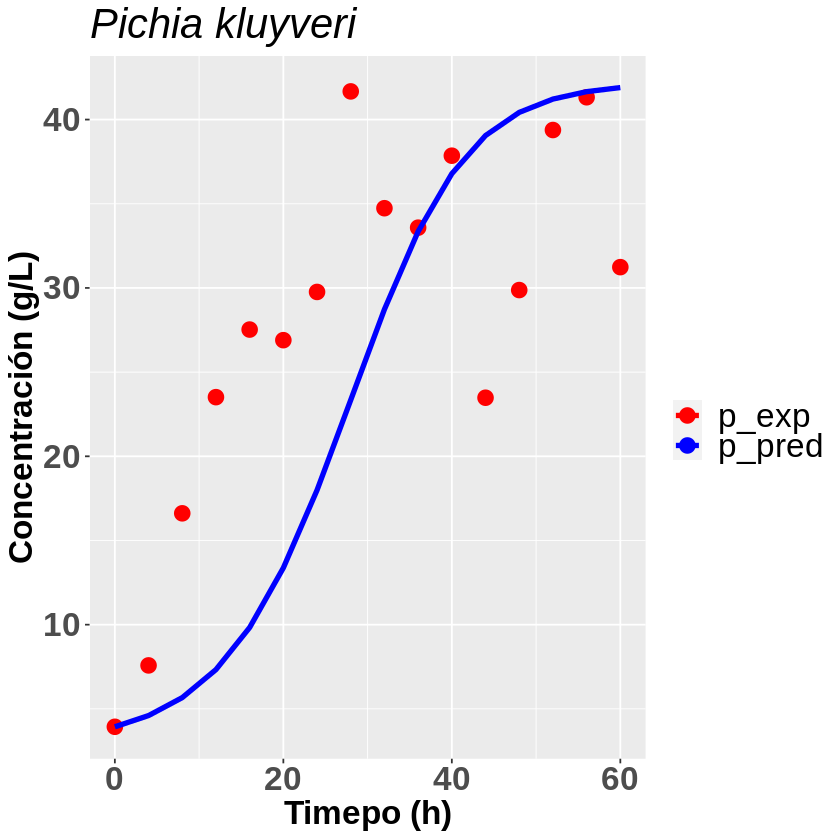

In [ ]:
# comparamos modelo y datos experimentales (sustrato)
ggplot(data_pk, aes(x=time)) +
  geom_point(aes(y = p, color = "p_exp"), size = 4) +
  geom_line(data = out_pk, aes(y = p, color = "p_pred"), lwd = 1.5) +
  scale_color_manual("", breaks = c("p_exp", "p_pred"), values = c("red", "blue")) +
  xlab("Timepo (h)") +
  ylab("Concentración (g/L)") +
  labs(title = "Pichia kluyveri") +
  theme(
        plot.title = element_text(size=25,face = "italic"),
        axis.text=element_text(size=20, face = "bold"),
        axis.title=element_text(size=20,face="bold"),
        legend.title = element_text(size=20), 
        legend.text = element_text(size=20))

Se observa una gran dispersión de los datos. Debido a esto es difícil un buen ajuste del modelo. Se observan algunos valores atípicos en los datos que se salen mucho de la tendecia general. Estos valores se pueden deben a errores experimentales. 

Tabla 5. Parámetros encontrados al hacer la optimización con datos de la levadura *Pichia kluyveri*

|Parámetro|	Valor|
|:---:|:---:|
|$\mu_{max}$|	$0.6694 h^{-1}$|
|$k_s$|	$390.127$ g/L|
|$Y_{xs}$|	$0.0822$|
|$Y_{px}$|	$5.2523$|

In [ ]:
print(p_opt_pk)

      mu_max           ks          Yxs          Ypx 
  0.66946444 390.12757424   0.08225718   5.25235052 


### Rendimientos

Rendimientos obtendios mediante (5) y (6)

In [ ]:
cat("Yxs: ", yield_xs(data_pk), "\n")
cat("Ypx: ", yield_px(data_pk))

Yxs:  0.1201317 
Ypx:  2.663495

Rendimientos obtenidos mediante la optimización 

In [ ]:
cat("Yxs: ", p_opt_pk["Yxs"], "\n")
cat("Ypx: ", p_opt_pk["Ypx"])

Yxs:  0.08225718 
Ypx:  5.252351

El rendimeinto $Y_{xs}$ es bastante similar en ambos casos. Por otro lado, el rendimiento $Y_{px}$ es considerablemente mayor en la optimización que calculado con (6). Si observamos la gráfica del producto vemos la razón. En los datos experimentales existe un valor atípico al final del proceso que es demasiado bajo y esto causa la diferencia.

## Optimización paramétrica con datos de *Zygosaccharomyces bailii*

In [ ]:
# realizar la optimización paramétrica
set.seed(123) # para reproducir estos resultados 
GA_zb <- ga(type = "real-valued",
      fitness = cost, 
      data = data_zb,
      lower = rep(0, 4),
      upper = c(3,500,1,20),
      popSize = 50,
      pcrossover = 0.8,
      pmutation = 0.1,
      elitism = 2,
      maxiter = 100,
      maxFitness = 0,
      names = names(p))

In [ ]:
print(GA_zb@solution)
cat("error: ", -GA_zb@fitnessValue)

       mu_max       ks       Yxs      Ypx
[1,] 1.279502 342.6706 0.1071413 5.457482
error:  390.5016

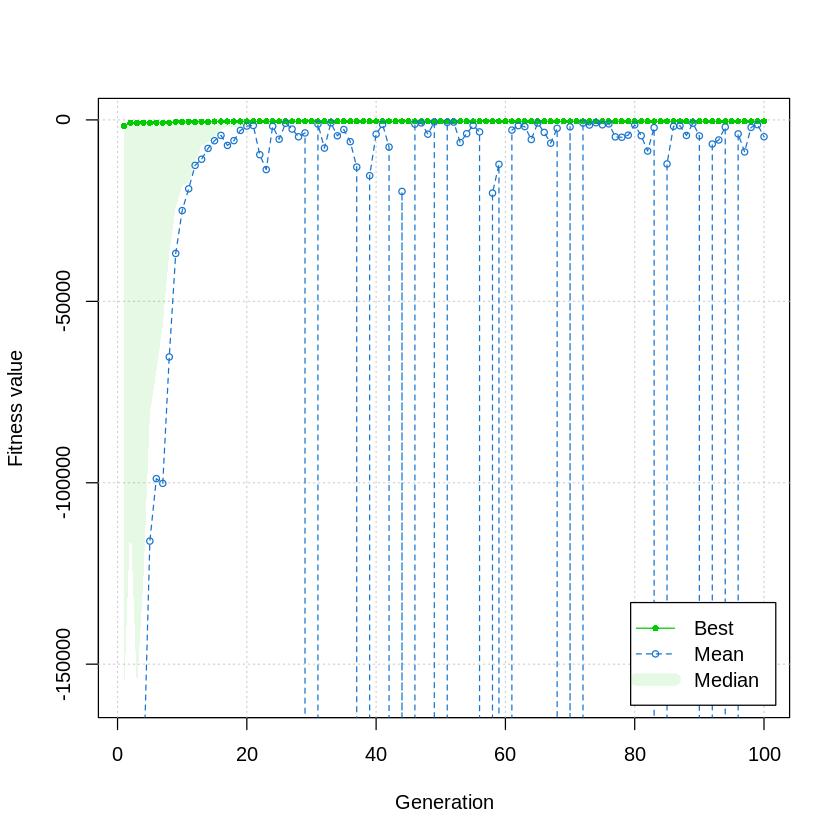

In [ ]:
# mostrar evolución del algoritmo
plot(GA_zb)

### Comparar simulación con parámetros óptimos y datos experimentales

In [ ]:
# parámetros óptimos para la comparación 
p_opt_zb <- GA_zb@solution[1,]

In [ ]:
# condiciones iniciales (siempre debemos tomar las condiciones iniciales para la simulación
# de los datos experimentales si lo que queremos es comparar u optimizar)
s <- c(s = data_zb$s[1], x = data_zb$x[1], p = data_zb$p[1])

In [ ]:
# tiempo de integración (lo mismo con el tiempo)
times <- data_zb$time

In [ ]:
# simular con parámetros óptimos 
out_zb <- ode(y=s, times = times, parms = p_opt_zb, func = model, method = "rk4")
out_zb <- as.data.frame(out_zb)

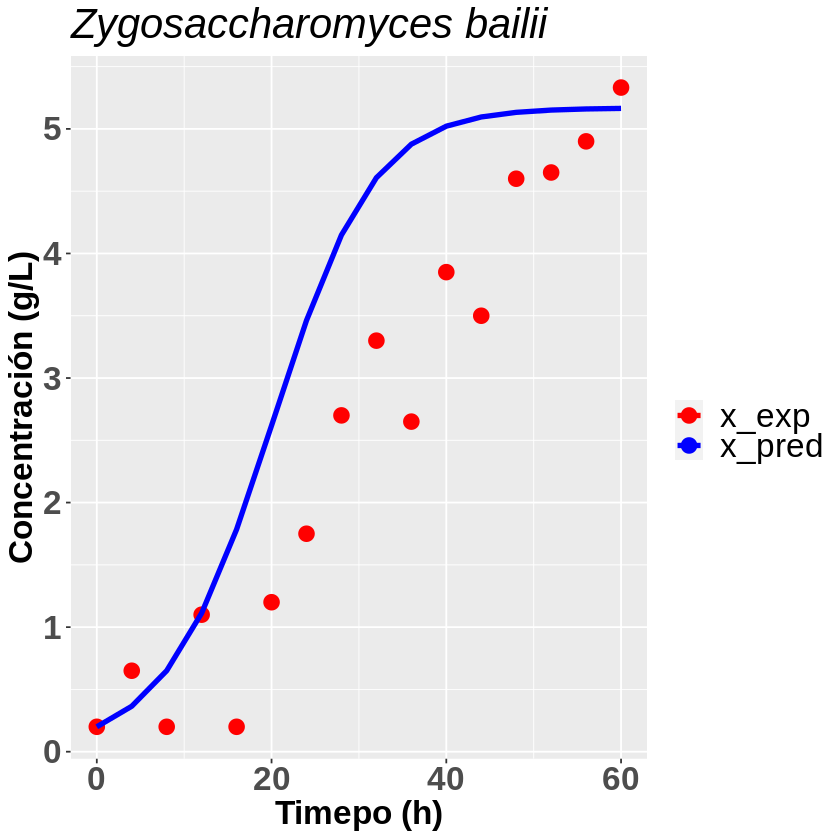

In [ ]:
# comparamos modelo y datos experimentales (biomasa)
ggplot(data_zb, aes(x=time)) +
  geom_point(aes(y = x, color = "x_exp"), size = 4) +
  geom_line(data = out_zb, aes(y = x, color = "x_pred"), lwd = 1.5) +
  scale_color_manual("", breaks = c("x_exp", "x_pred"), values = c("red", "blue")) +
  xlab("Timepo (h)") +
  ylab("Concentración (g/L)") +
  labs(title = "Zygosaccharomyces bailii") +
  theme(
        plot.title = element_text(size=25,face = "italic"),
        axis.text=element_text(size=20, face = "bold"),
        axis.title=element_text(size=20,face="bold"),
        legend.title = element_text(size=20), 
        legend.text = element_text(size=20))

El crecimiento de biomasa parece tener un comportamiento lineal en las observaciones. Esto hace que el ajuste del modelo no sea muy bueno para los valores intermedios y finales. Aun así, el ajuste parece ser bueno con las observaciones de la hora 30 a 50 siendo las que más difieren

Warning message:
“Removed 7 rows containing missing values (geom_point).”


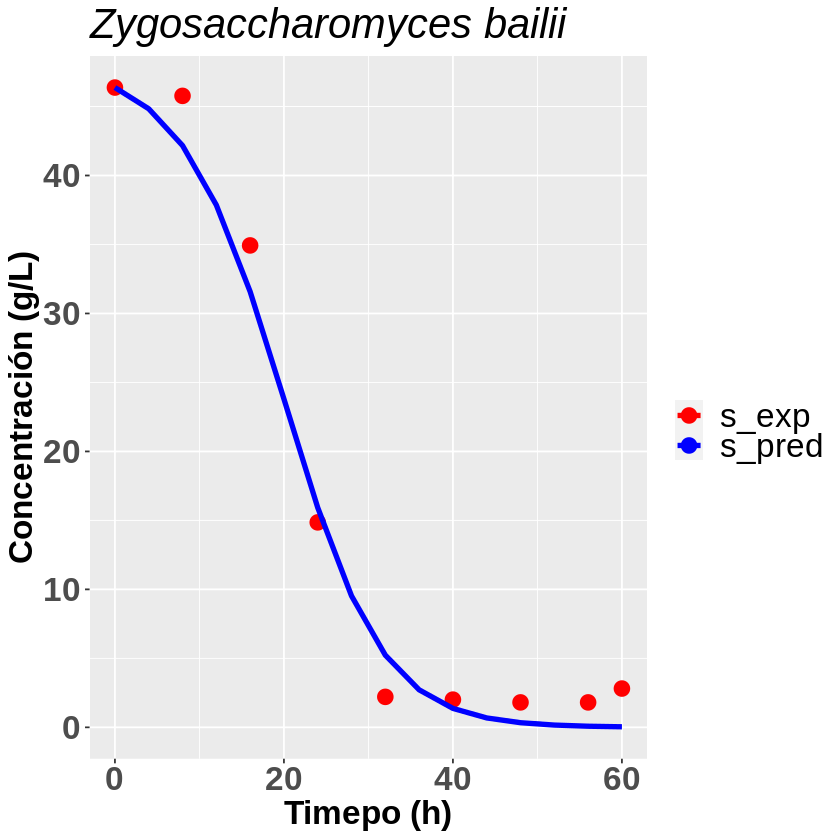

In [ ]:
# comparamos modelo y datos experimentales (sustrato)
ggplot(data_zb, aes(x=time)) +
  geom_point(aes(y = s, color = "s_exp"), size = 4) +
  geom_line(data = out_zb, aes(y = s, color = "s_pred"), lwd = 1.5) +
  scale_color_manual("", breaks = c("s_exp", "s_pred"), values = c("red", "blue")) +
  xlab("Timepo (h)") +
  ylab("Concentración (g/L)") +
  labs(title = "Zygosaccharomyces bailii") +
  theme(
        plot.title = element_text(size=25,face = "italic"),
        axis.text=element_text(size=20, face = "bold"),
        axis.title=element_text(size=20,face="bold"),
        legend.title = element_text(size=20), 
        legend.text = element_text(size=20))

En este caso el ajuste parace ser bastante bueno. La mayoría de las observaciones quedan muy cerca de las predicciones. La diferencia se aprecia únicamente al final donde los datos indican una concentración mayor que las predichas por el modelo, sin embargo, dado que en teoría la concentración de sustrato no puede aumentar, estas observaciones pueden tener error en su medición. 

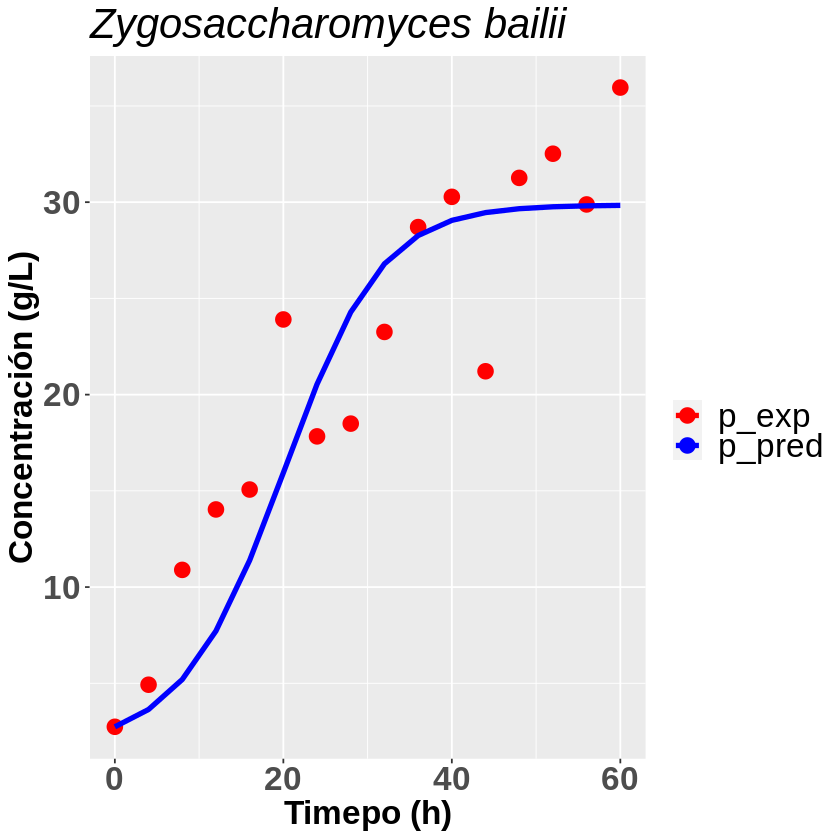

In [ ]:
# comparamos modelo y datos experimentales (producto)
ggplot(data_zb, aes(x=time)) +
  geom_point(aes(y = p, color = "p_exp"), size = 4) +
  geom_line(data = out_zb, aes(y = p, color = "p_pred"), lwd = 1.5) +
  scale_color_manual("", breaks = c("p_exp", "p_pred"), values = c("red", "blue")) +
  xlab("Timepo (h)") +
  ylab("Concentración (g/L)") +
  labs(title = "Zygosaccharomyces bailii") +
  theme(
        plot.title = element_text(size=25,face = "italic"),
        axis.text=element_text(size=20, face = "bold"),
        axis.title=element_text(size=20,face="bold"),
        legend.title = element_text(size=20), 
        legend.text = element_text(size=20))

La concentración de producto parece incrementar linealmente. Se observa una gran dispersión en los datos. Aun así el ajuste parece adecuado. Siendo solamente la observación de la hora 44 la que difiere bastante de la predicción 

Tabla 6. Parámetros encontrados al hacer la optimización con datos de la levadura *Zygosaccharomyces bailii*

|Parámetro|	Valor|
|:---:|:---:|
|$\mu_{max}$|	$1.279 h^{-1}$|
|$k_s$|	$342.670$ g/L|
|$Y_{xs}$|	$0.1071$|
|$Y_{px}$|	$5.457$|

In [ ]:
print(p_opt_zb)

     mu_max          ks         Yxs         Ypx 
  1.2795025 342.6705565   0.1071413   5.4574825 


### Rendimientos

Rendimientos obtendios mediante (5) y (6)

In [ ]:
cat("Yxs: ", yield_xs(data_zb), "\n")
cat("Ypx: ", yield_px(data_zb))

Yxs:  0.117799 
Ypx:  6.472411

Rendimientos obtenidos mediante la optimización 

In [ ]:
cat("Yxs: ", p_opt_zb["Yxs"], "\n")
cat("Ypx: ", p_opt_zb["Ypx"])

Yxs:  0.1071413 
Ypx:  5.457482

Aquí la diferencia entre los rendimientos calculado con (5) y (6) no difiere mucho de los obtenidos mediante la optimización. 

## Optimización paramétrica con datos de *Zigosaccharomyces rouxi*

In [ ]:
# realizar la optimización paramétrica
set.seed(123) # para reproducir estos resultados 
GA_zr <- ga(type = "real-valued",
      fitness = cost, 
      data = data_zr,
      lower = rep(0, 4),
      upper = c(3,500,1,20),
      popSize = 50,
      pcrossover = 0.8,
      pmutation = 0.1,
      elitism = 2,
      maxiter = 100,
      maxFitness = 0,
      names = names(p))

In [ ]:
print(GA_zr@solution)
cat("error: ", -GA_zr@fitnessValue)

        mu_max       ks       Yxs      Ypx
[1,] 0.8110987 446.3537 0.1950917 3.335167
error:  562.1318

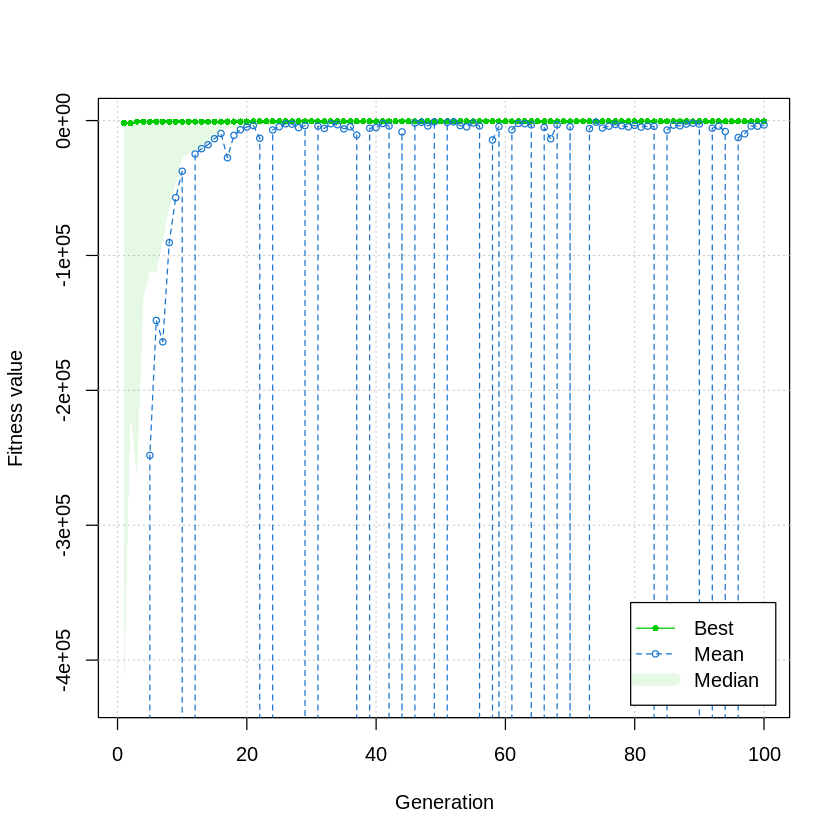

In [ ]:
# mostrar evolución del algoritmo
plot(GA_zr)

### Comparar simulación con parámetros óptimos y datos experimentales

In [ ]:
# parámetros óptimos para la comparación 
p_opt_zr <- GA_zr@solution[1,]

In [ ]:
# condiciones iniciales (siempre debemos tomar las condiciones iniciales para la simulación
# de los datos experimentales si lo que queremos es comparar u optimizar)
s <- c(s = data_zr$s[1], x = data_zr$x[1], p = data_zr$p[1])

In [ ]:
# tiempo de integración (lo mismo con el tiempo)
times <- data_zr$time

In [ ]:
# simular con parámetros óptimos 
out_zr <- ode(y=s, times = times, parms = p_opt_zr, func = model, method = "rk4")
out_zr <- as.data.frame(out_zr)

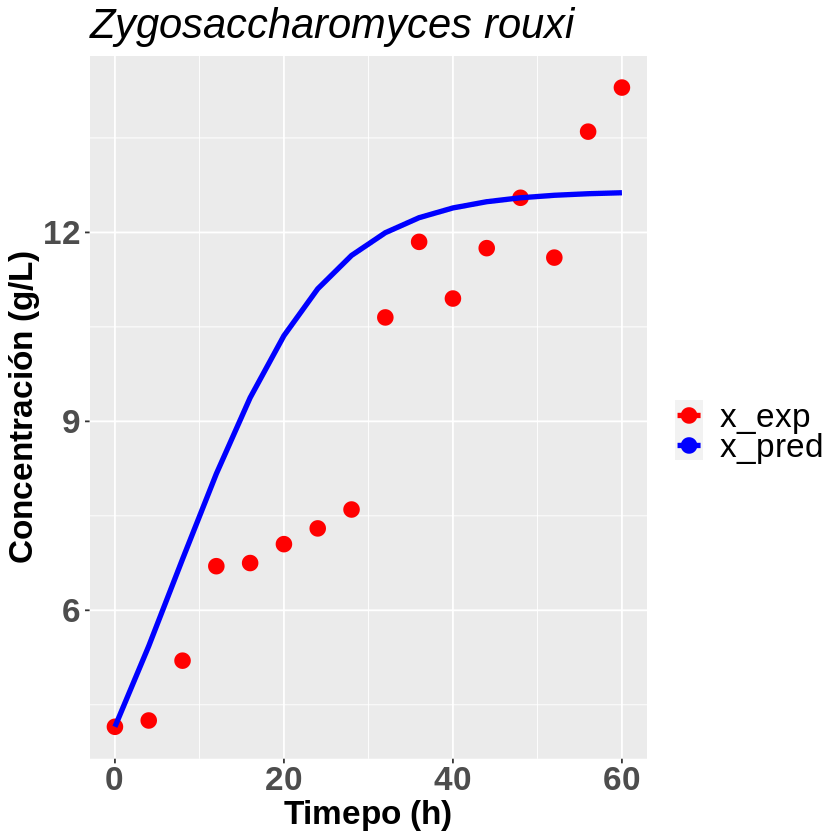

In [ ]:
# comparamos modelo y datos experimentales (biomasa)
ggplot(data_zr, aes(x=time)) +
  geom_point(aes(y = x, color = "x_exp"), size = 4) +
  geom_line(data = out_zr, aes(y = x, color = "x_pred"), lwd = 1.5) +
  scale_color_manual("", breaks = c("x_exp", "x_pred"), values = c("red", "blue")) +
  xlab("Timepo (h)") +
  ylab("Concentración (g/L)") +
  labs(title = "Zygosaccharomyces rouxi") +
  theme(
        plot.title = element_text(size=25,face = "italic"),
        axis.text=element_text(size=20, face = "bold"),
        axis.title=element_text(size=20,face="bold"),
        legend.title = element_text(size=20), 
        legend.text = element_text(size=20))

Vemos que el comportamiento de los datos experimentales es difícil de reproducir. Parece que el modelo sobreestima el valor de la concentración de biomasa, sin embargo al final existen observaciones que superan las predicciones. Incluso así, el ajuste parece ser bueno, siendo solo las observaciones de la hora 20 a 30 las que difirene en mayor medida de las predicciones 

Warning message:
“Removed 7 rows containing missing values (geom_point).”


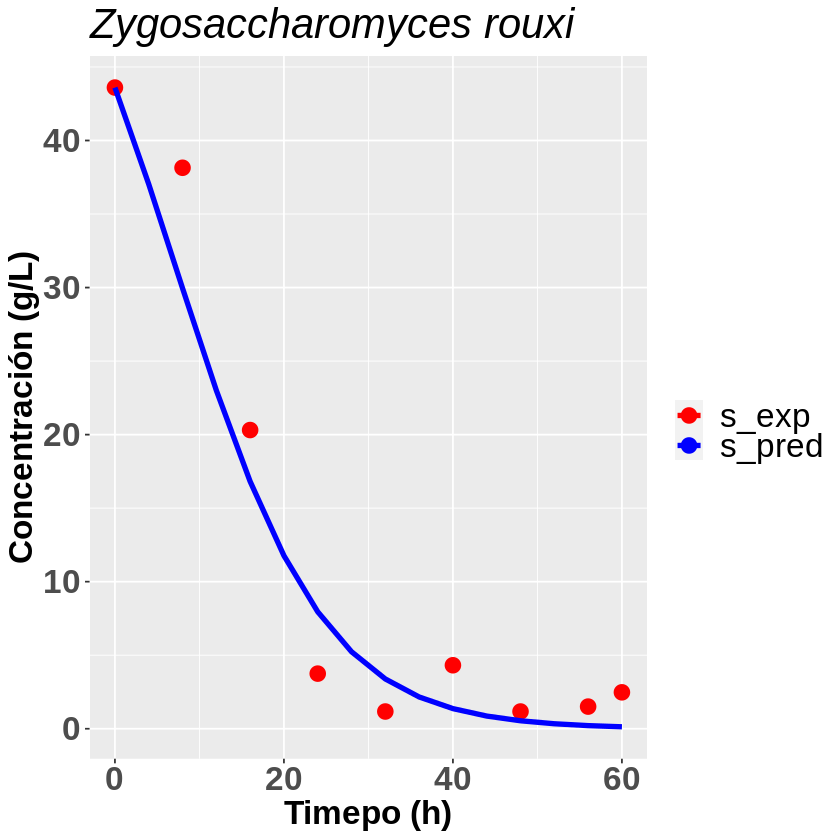

In [ ]:
# comparamos modelo y datos experimentales (sustrato)
ggplot(data_zr, aes(x=time)) +
  geom_point(aes(y = s, color = "s_exp"), size = 4) +
  geom_line(data = out_zr, aes(y = s, color = "s_pred"), lwd = 1.5) +
  scale_color_manual("", breaks = c("s_exp", "s_pred"), values = c("red", "blue")) +
  xlab("Timepo (h)") +
  ylab("Concentración (g/L)") +
  labs(title = "Zygosaccharomyces rouxi") +
  theme(
        plot.title = element_text(size=25,face = "italic"),
        axis.text=element_text(size=20, face = "bold"),
        axis.title=element_text(size=20,face="bold"),
        legend.title = element_text(size=20), 
        legend.text = element_text(size=20))

Aquí el ajuste parece bastante bueno. El modelo predice bien el decremento acelerado en la concetración de sustrato durante las primeras 40 horas, para después mantenerse con una concentración baja durante en la fase estacionaria. 

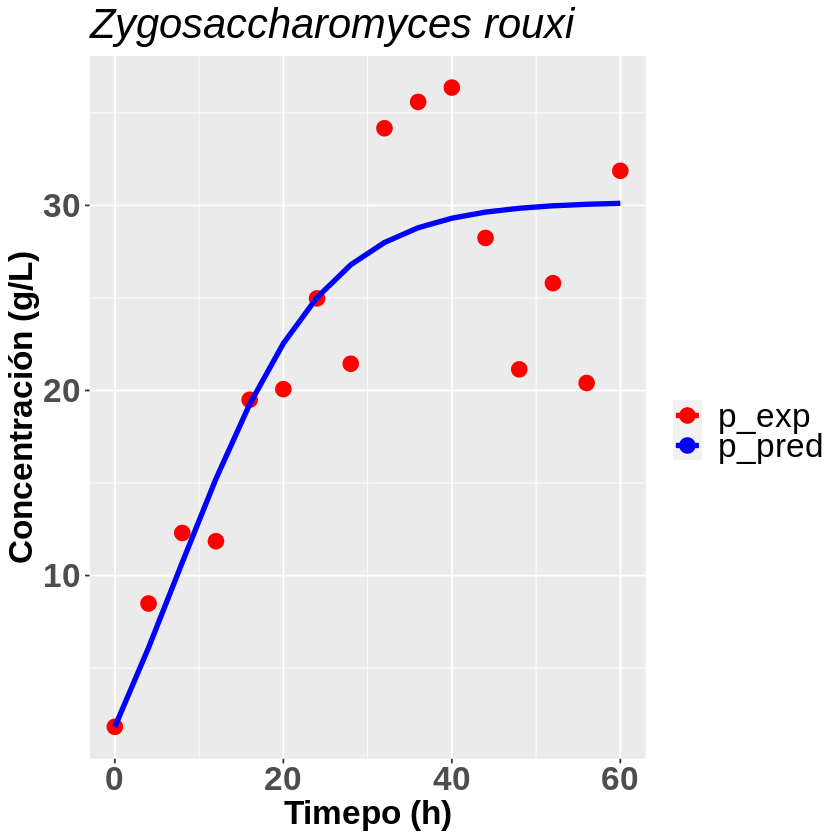

In [ ]:
# comparamos modelo y datos experimentales (producto)
ggplot(data_zr, aes(x=time)) +
  geom_point(aes(y = p, color = "p_exp"), size = 4) +
  geom_line(data = out_zr, aes(y = p, color = "p_pred"), lwd = 1.5) +
  scale_color_manual("", breaks = c("p_exp", "p_pred"), values = c("red", "blue")) +
  xlab("Timepo (h)") +
  ylab("Concentración (g/L)") +
  labs(title = "Zygosaccharomyces rouxi") +
  theme(
        plot.title = element_text(size=25,face = "italic"),
        axis.text=element_text(size=20, face = "bold"),
        axis.title=element_text(size=20,face="bold"),
        legend.title = element_text(size=20), 
        legend.text = element_text(size=20))

Existe una gran dispersión en los datos, por lo que es difícil realizar el ajuste. Sin embargo, se observa que la inicio de la fermentación durante las primeras 30 horas las predicciones concuerdan muy bien con las observaciones. En el resto de las horas parece haber valores muy altos y bajos de concentración comparados con los valores predichos por el modelo. Sabemos que durante la fermentación la concentración de producto no puede disminuir, por lo cual estas observaciones se pueden deber a errores experimentales

Tabla 7. Parámetros encontrados al hacer la optimización con datos de la levadura Zygosaccharomyces rouxi

|Parámetro|	Valor|
|:---:|:---:|
|$\mu_{max}$|	$0.811 h^{-1}$|
|$k_s$|	$446.367$ g/L|
|$Y_{xs}$|	$0.195$|
|$Y_{px}$|	$3.335$|

In [ ]:
print(p_opt_zr)

     mu_max          ks         Yxs         Ypx 
  0.8110987 446.3537385   0.1950917   3.3351674 


### Rendimientos

Rendimientos obtendios mediante (5) y (6)

In [ ]:
cat("Yxs: ", yield_xs(data_zr), "\n")
cat("Ypx: ", yield_px(data_zr))

Yxs:  0.2468245 
Ypx:  2.9595

Rendimientos obtenidos mediante la optimización 

In [ ]:
cat("Yxs: ", p_opt_zr["Yxs"], "\n")
cat("Ypx: ", p_opt_zr["Ypx"])

Yxs:  0.1950917 
Ypx:  3.335167

Aquí se observa una diferencia entre los rendimientos calculados con (5) y (6) y los rendimientos obtenidos de la optimización. Aun así la diferencia no es tan grande y se observa congruencia 